# Objective
Predict total sales for every product and store in the next month

In [86]:
import gc
import numpy as np
import os, subprocess
import pandas as pd
import seaborn as sns
import time

from itertools import product
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

%matplotlib inline

#### Input parameters ########
model_seed = 102
sample_seed = 103              # for sampling the dataframe

#### model params ############
n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100
##############################

fontsize = 14
ticklabelsize = 14
##############################

print(os.listdir("./"))

['sales_train.csv', 'shops.csv', 'test.csv', 'submission.csv', 'submission_previous_benchmark.csv', 'item_categories.csv', '.ipynb_checkpoints', 'v1.ipynb', 'items.csv', 'sample_submission.csv']


# Common functions

In [36]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load the files

*File descriptions*
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

*Data fields*
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [37]:
# the training set. Daily historical data from January 2013 to October 2015.
# So date_block_num is from 0 to 33 (for 34 months)
sales = pd.read_csv("sales_train.csv") 
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [38]:
# the test set. You need to forecast the sales for these shops and products for November 2015.
# ie. date_block_num = 34
test = pd.read_csv("test.csv") 
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [39]:
# a sample submission file in the correct format.
sample_submission = pd.read_csv("sample_submission.csv") 
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [40]:
# supplemental information about the items/products.
items = pd.read_csv("items.csv") 
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [41]:
# supplemental information about the items categories.
item_categories = pd.read_csv("item_categories.csv") 
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [42]:
# supplemental information about the shops.
shops = pd.read_csv("shops.csv") 
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# Data Exploration

In [43]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [44]:
sales['item_cnt_day'].value_counts(dropna=False).head(10)

 1.0    2629372
 2.0     194201
 3.0      47350
 4.0      19685
 5.0      10474
-1.0       7252
 6.0       6338
 7.0       4057
 8.0       2903
 9.0       2177
Name: item_cnt_day, dtype: int64

In [45]:
# Count number of nulls for each column
sales.isnull().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

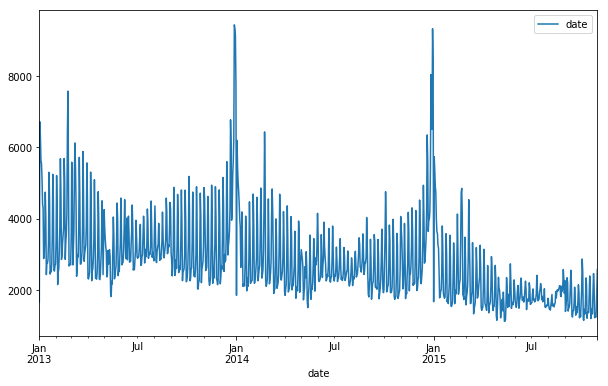

In [46]:
# Plot number of items sold across the days for all shops
sales.groupby("date").agg({"date": "count"}).plot(figsize=(10, 6))

We see two peaks that happened at Jan 2014 and Jan 2015

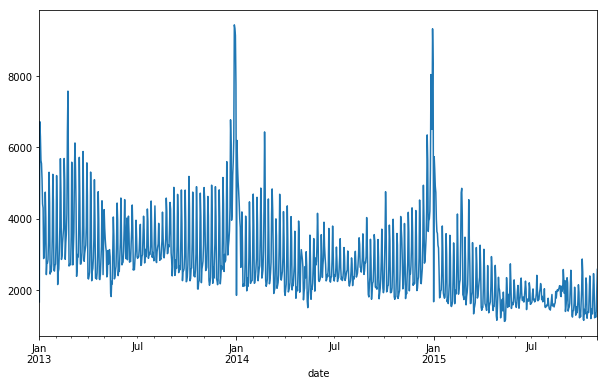

In [47]:
# Plot number of items sold across the days for all shops
sales.groupby("date").size().plot(figsize=(10, 6))

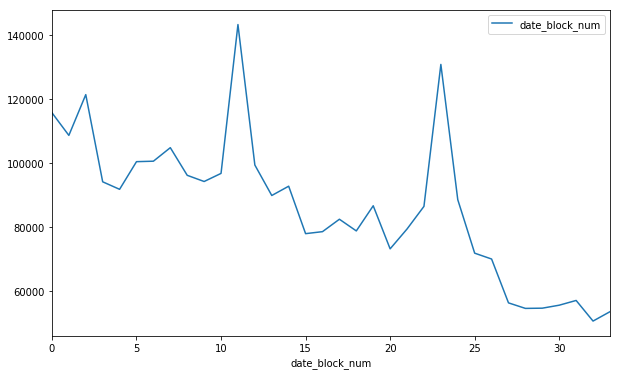

In [48]:
# Plot number of items sold across the months for all shops
sales.groupby("date_block_num").agg({'date_block_num': 'count'}).plot(figsize=(10, 6))

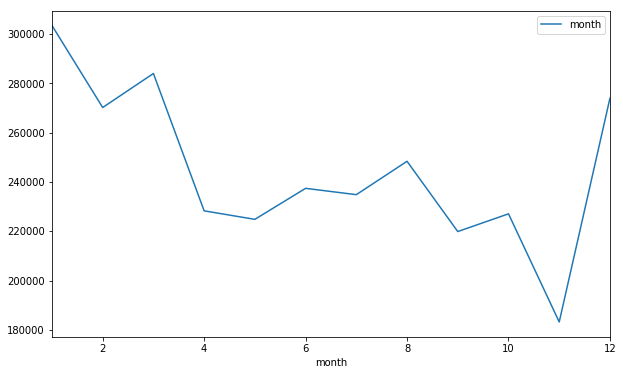

In [49]:
# Plot the number of items sold for each month Jan to Dec for all shops
sales['month'] = sales['date'].dt.month
sales.groupby("month").agg({'month': 'count'}).plot(figsize=(10, 6))

Most items are sold in Jan, Mar, Dec, Feb.

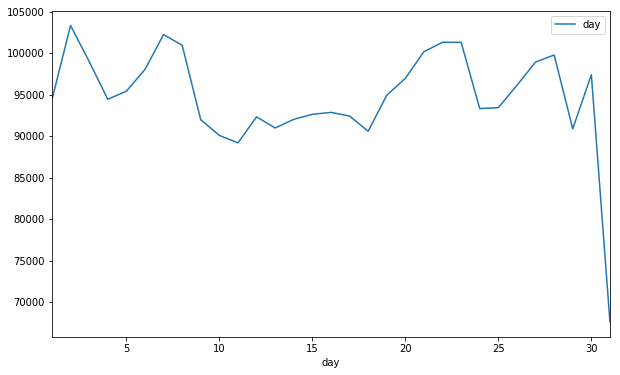

In [50]:
# Plot the number of items sold for each day for all shops
sales['day'] = sales['date'].dt.day
sales.groupby("day").agg({'day': 'count'}).plot(figsize=(10, 6))

Fewer items sold on 31

In [51]:
# For train set, get number of shop_id's and number of item_id's
sales['item_id'].nunique(), sales['shop_id'].nunique()

(21807, 60)

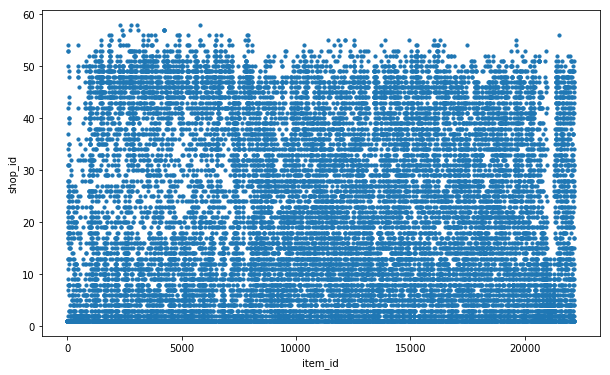

In [52]:
# For train set, does every item exist in all shops for training data?
# Plot no. of shop_id's this item_id appeared in versus item_id
sales.groupby("item_id").agg({"shop_id": "nunique"}).reset_index().plot.scatter("item_id", "shop_id", figsize=(10, 6), s=10);


No, for the 21807 unique items, there's no single item exits in all 60 shops (for train set)

In [53]:
# For test set, get number of shop_id's and number of item_id's
test['item_id'].nunique(), test['shop_id'].nunique()

(5100, 42)

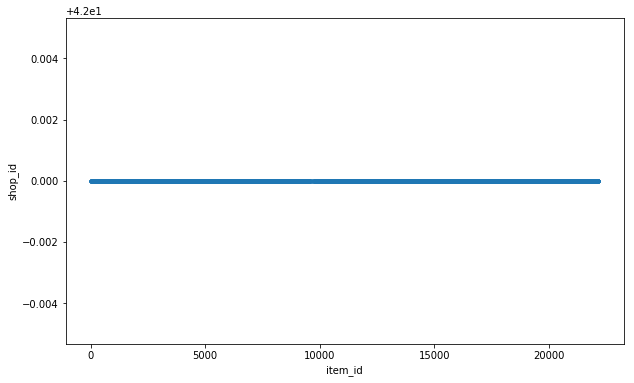

In [54]:
# For test set, does every item exist in all shops for training data?
# Plot no. of shop_id's this item_id appeared in versus item_id
test.groupby("item_id").agg({"shop_id": "nunique"}).reset_index().plot.scatter("item_id", "shop_id", figsize=(10, 6), s=10);


Yes, for the 5100 unique items, each item exists in all 42 shops

# Investigate data leak

For time series data, if the train/test split is not based on time, then immediately you have a data leak. But here it seems train/test split is based on time. 

# Aggregate data and create features

In [55]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
# product: cartesian product, equivalent to a nested for-loop
# *[a,b,c]: splits the sequence into separate arguments for the function call.

# Also append test set data
block_num = 34
cur_shops = test['shop_id'].unique()
cur_items = test['item_id'].unique()
grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
# vstack: Stack arrays in sequence vertically (row wise).
# index    shop_id	item_id	date_block_num
# 0	59	22154	0
# 1	59	2552	0
# 2	59	2554	0
# 3	59	2555	0

grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [56]:
#get aggregated values for (shop_id, item_id, date_block_num)
# get the target values ie. items sold for this (shop_id, item_id, date_block_num) combination
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
#     shop_id	item_id	date_block_num	item_cnt_day
#                                       target
# 0	0	30	1	31.0
# 1	0	31	1	11.0
# 2	0	32	0	6.0
# 3	0	32	1	10.0

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

gb.head()

/Users/yibin/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [57]:
#join target data to the grid
# all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
all_data = grid.merge(gb, 
                      left_on=['shop_id', 'item_id', 'date_block_num'], 
                      right_on=['shop_id', 'item_id', 'date_block_num'],
                      how='left')

# fill nans with 0
all_data = all_data.fillna(value = 0)

#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

all_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


In [58]:
# Same as above but with (shop_id, date_block_num) aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = all_data.merge(gb, 
                      left_on=['shop_id', 'date_block_num'], 
                      right_on=['shop_id', 'date_block_num'],
                      how='left').fillna(0)
all_data.head()

/Users/yibin/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,target_shop
0,0,19,0,0.0,5578.0
1,0,27,0,0.0,5578.0
2,0,28,0,0.0,5578.0
3,0,29,0,0.0,5578.0
4,0,32,0,6.0,5578.0


In [59]:
# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = all_data.merge(gb, 
                      left_on=['item_id', 'date_block_num'], 
                      right_on=['item_id', 'date_block_num'],
                      how='left').fillna(0)
all_data.head()

/Users/yibin/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,target_shop,target_item
0,0,19,0,0.0,5578.0,1.0
1,0,27,0,0.0,5578.0,7.0
2,0,28,0,0.0,5578.0,8.0
3,0,29,0,0.0,5578.0,4.0
4,0,32,0,6.0,5578.0,299.0


In [60]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

Now we generate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [61]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 
cols_to_rename

['target', 'target_item', 'target_shop']

In [62]:
index_cols

['shop_id', 'item_id', 'date_block_num']

In [63]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    # E.g. date_block_num of 0 becomes 1, for month_shift = 1.
    # So when this is merged with data_block_num of 1 in all_date, this will represent lag of 1.
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage, because these are targets and will have data leak
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
print("to_drop_cols = " + str(to_drop_cols))

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

A Jupyter Widget


to_drop_cols = ['target_shop', 'target', 'target_item', 'date_block_num']


In [64]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,2,27,12,0.0,890.0,1.0,0.0,4.0,1322.0,0.0,...,0.0,1.0,945.0,0.0,1.0,875.0,1.0,7.0,1146.0,19
1,2,30,12,0.0,890.0,58.0,0.0,47.0,1322.0,0.0,...,0.0,13.0,945.0,0.0,19.0,875.0,0.0,0.0,0.0,40
2,2,31,12,0.0,890.0,15.0,0.0,25.0,1322.0,0.0,...,0.0,19.0,945.0,0.0,25.0,875.0,0.0,0.0,0.0,37
3,2,32,12,1.0,890.0,84.0,0.0,89.0,1322.0,0.0,...,0.0,59.0,945.0,0.0,72.0,875.0,0.0,299.0,1146.0,40
4,2,33,12,1.0,890.0,42.0,1.0,42.0,1322.0,2.0,...,0.0,43.0,945.0,0.0,35.0,875.0,1.0,61.0,1146.0,37


In [65]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 25 columns):
shop_id               int32
item_id               int32
date_block_num        int32
target                float32
target_shop           float32
target_item           float32
target_lag_1          float32
target_item_lag_1     float32
target_shop_lag_1     float32
target_lag_2          float32
target_item_lag_2     float32
target_shop_lag_2     float32
target_lag_3          float32
target_item_lag_3     float32
target_shop_lag_3     float32
target_lag_4          float32
target_item_lag_4     float32
target_shop_lag_4     float32
target_lag_5          float32
target_item_lag_5     float32
target_shop_lag_5     float32
target_lag_12         float32
target_item_lag_12    float32
target_shop_lag_12    float32
item_category_id      int32
dtypes: float32(21), int32(4)
memory usage: 683.8 MB


In [66]:
all_data['date_block_num'].unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34])

In all_data:
* target means the number of items sold for this (shop_id, item_id, date_block_num) combination
* target_shop means the number of items sold for this (shop_id, date_block_num) combination. Note target_shop > target
* target_item means the number of items sold for this (item_id, date_block_num) combination. Note target_item > target
* target_lag_1 means the number of items sold for this (shop_id, item_id, (date_block_num-1)) combination. e.g. if data_block_num = 12, then target_lag_1 is for date_block_num = 11
* date_block_num is from 12 to 34. You need to predict for 34.

# Mean Encoding for item_id

In [67]:
from sklearn.model_selection import KFold

y_tr = all_data['target'].values # target variable
kf = KFold(n_splits=5, shuffle=False)

for tr_ind, val_ind in kf.split(all_data):
    X_tr, X_val = all_data.iloc[tr_ind], all_data.iloc[val_ind]
    
    # Calculate a mapping: {item_id: target_mean}
    item_id_target_mean = X_tr.groupby('item_id').target.mean()

    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    all_data.loc[all_data.index[val_ind], 'item_target_enc'] = X_val['item_id'].map(item_id_target_mean)
#     print(X_val)
    

# print(train_new.head())
#         shop_id  item_id  date_block_num  target  item_target_enc  \
# 139255        0       19               0     0.0         0.022222   
# 141495        0       27               0     0.0         0.056834   
# 144968        0       28               0     0.0         0.141176   
# 142661        0       29               0     0.0         0.037383   
# 138947        0       32               0     6.0         1.319042   

#         item_target_enc_kfold  
# 139255                    NaN  
# 141495               0.038095  
# 144968               0.142857  
# 142661               0.000000  
# 138947               0.610375  
    
# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

# You will need to compute correlation like that
encoded_feature = all_data['item_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr) # 0.378101358646

0.375339600682


# Split into train, validation, test sets

We use date_block_num 12 to 32 for training, 33 for validation, 34 for test

In [68]:
to_drop_cols

['target_shop', 'target', 'target_item', 'date_block_num']

In [69]:
X_train = all_data[all_data['date_block_num']<=32].drop(to_drop_cols, axis = 1)
X_cv = all_data[all_data['date_block_num']==33].drop(to_drop_cols, axis = 1)
X_train_cv = all_data[all_data['date_block_num']<=33].drop(to_drop_cols, axis = 1)
X_test = all_data[all_data['date_block_num']==34].drop(to_drop_cols, axis = 1)

y_train = all_data[all_data['date_block_num']<=32][['shop_id', 'item_id', 'target']]
y_cv = all_data[all_data['date_block_num']==33][['shop_id', 'item_id', 'target']]
y_train_cv = all_data[all_data['date_block_num']<=33][['shop_id', 'item_id', 'target']]
y_test = all_data[all_data['date_block_num']==34][['shop_id', 'item_id', 'target']]

# Submit number of items sold in previous month as benchmark

In [71]:
y_test['item_cnt_month'] = X_test['target_lag_1']

In [73]:
y_test_merged = y_test.merge(test, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'], how='inner')
y_test_merged.head()

,shop_id,item_id,target,item_cnt_month,ID
0,2,30,0.0,0.0,22987
1,2,31,0.0,1.0,20994
2,2,32,0.0,0.0,20995
3,2,33,0.0,0.0,22492
4,2,38,0.0,0.0,22491


In [79]:
# Clip the item_cnt_month column to be [0, 20] as suggested in Final Project Advice #2
y_test_merged['item_cnt_month'] = y_test_merged['item_cnt_month'].clip(lower=0, upper=20)

In [81]:
y_test_merged[['ID', 'item_cnt_month']].to_csv("submission_previous_benchmark.csv", index=False)

This got the results as required in Final Project Advice #2:

    Your submission scored 1.16777, which is an improvement of your previous score of 2.15267. Great job!
<img src="kaggle_previous_benchmark.png">

# Train the model and get baseline

In [40]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train['target'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
       silent=True, subsample=1)

In [41]:
# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
mean_squared_error(y_cv['target'], est)

23.285973

We aim to do better than the RMSE metric above after tuning the model

# Tune XGBoost - number of trees

In [39]:
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV 
# GridSearchCV: The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.

from sklearn.model_selection import StratifiedKFold
# Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class.

tic = time.time()
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)
n_estimators = range(50, 500, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_cv, y_train_cv['target'])
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/yibin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Minutes taken = 7.1530920505523685
Best: -25.934030 using {'n_estimators': 50}
-25.934030 (48.411690) with: {'n_estimators': 50}
-25.990741 (48.080545) with: {'n_estimators': 100}
-25.988695 (47.875119) with: {'n_estimators': 150}
-26.011675 (47.826232) with: {'n_estimators': 200}
-26.022735 (47.807739) with: {'n_estimators': 250}
-26.031540 (47.783347) with: {'n_estimators': 300}
-26.032570 (47.761108) with: {'n_estimators': 350}
-26.021178 (47.726137) with: {'n_estimators': 400}
-25.977665 (47.635074) with: {'n_estimators': 450}


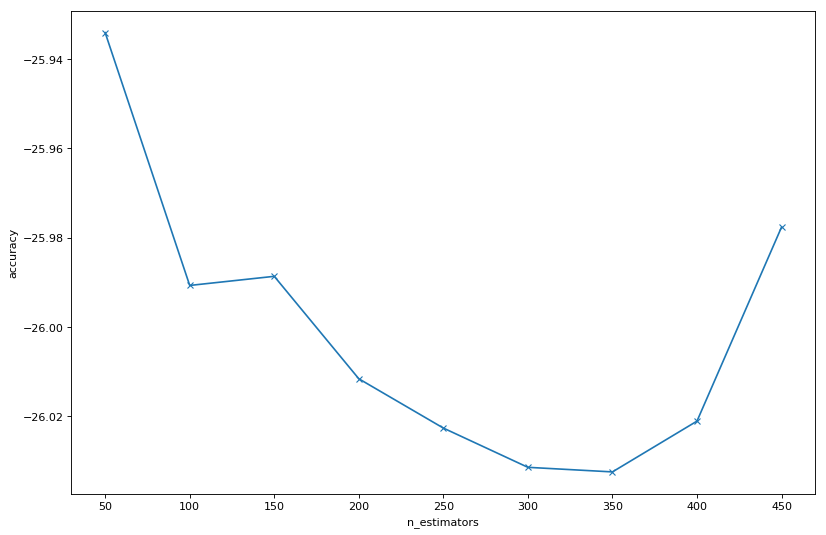

In [40]:
# plot
plt.figure(figsize=(12, 8), dpi=80)
plt.errorbar(n_estimators, means, marker='x')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

# Tune XGBoost - number of trees and size of tree

In [41]:
tic = time.time()
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)
n_estimators = range(300, 401, 50)
max_depth = range(1, 31, 5)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_cv, y_train_cv['target'])
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/yibin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Minutes taken = 117.0369084517161
Best: -25.187998 using {'max_depth': 1, 'n_estimators': 400}
-25.243533 (47.615756) with: {'max_depth': 1, 'n_estimators': 300}
-25.216308 (47.556733) with: {'max_depth': 1, 'n_estimators': 350}
-25.187998 (47.497282) with: {'max_depth': 1, 'n_estimators': 400}
-26.369913 (48.335839) with: {'max_depth': 6, 'n_estimators': 300}
-26.363950 (48.314584) with: {'max_depth': 6, 'n_estimators': 350}
-26.357280 (48.290038) with: {'max_depth': 6, 'n_estimators': 400}
-26.170714 (47.691244) with: {'max_depth': 11, 'n_estimators': 300}
-26.183098 (47.679672) with: {'max_depth': 11, 'n_estimators': 350}
-26.190535 (47.672816) with: {'max_depth': 11, 'n_estimators': 400}
-26.091697 (47.405446) with: {'max_depth': 16, 'n_estimators': 300}
-26.097764 (47.402819) with: {'max_depth': 16, 'n_estimators': 350}
-26.099985 (47.400282) with: {'max_depth': 16, 'n_estimators': 400}
-26.315196 (47.299395) with: {'max_depth': 21, 'n_estimators': 300}
-26.316424 (47.299093) with

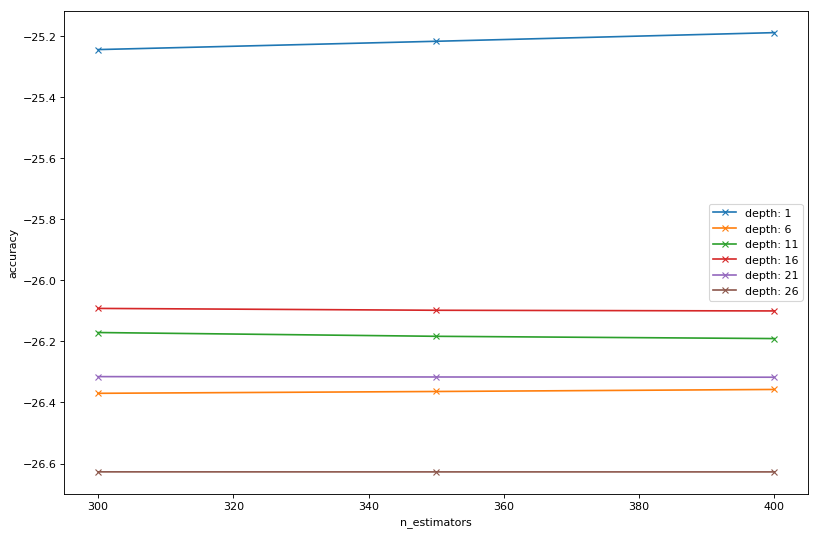

In [45]:
# plot results
plt.figure(figsize=(12, 8), dpi=80)
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value), marker='x')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

# Tune model using Hyperopt

* Tune model using hyperopt using the tutorial in : https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model
* This took a lot of time. Just tuning n_estimators hp.quniform('n_estimators', 100, 200, 100) took 91 mins

In [38]:
import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

SEED = model_seed

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train['target'])
    dvalid = xgb.DMatrix(X_cv, label=y_cv['target'])
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    
#     score = roc_auc_score(y_cv['target'], predictions)
#     # TODO: Add the importance for the selected features
#     print("\tScore {0}\n\n".format(score))
#     # The score function should return the loss (1-score)
#     # since the optimize function looks for the minimum
#     loss = 1 - score

    loss = mean_squared_error(y_cv['target'], predictions)
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=model_seed):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
#         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
#         'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
#         # A problem with max_depth casted to float instead of int with
#         # the hp.quniform method.
#         'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
#         'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
#         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
#         'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
#         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#         'eval_metric': 'rmse',
#         'objective': 'reg:linear',
#         # Increase this number if you have more cores. Otherwise, remove it and it will default 
#         # to the maxium number. 
#         'nthread': 4,
#         'booster': 'gbtree',
#         'tree_method': 'exact',
#         'silent': 1,
#         'seed': random_state
        
#         # Use params as suggested in the Advanced ML course
#         'eta': 0.01,
#         'max_depth':  hp.quniform('max_depth', 10, 30, 1),
#         'min_child_weight': hp.quniform('min_child_weight', 0, 100, 1),
#         'subsample': hp.quniform('subsample', 0.1, 1.0, 0.1),
#         'gamma': hp.quniform('gamma', 0.0, 30, 5),
#         'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
#         'objective': 'reg:linear',
#         'nthread': 4,
#         'silent': 1,
#         'num_round': 2500,
#         'seed': random_state,
#         'early_stopping_rounds': 100
        
        # Try less params to save tuning time
        'n_estimators': hp.quniform('n_estimators', 100, 200, 100),
        'eta': 0.01,
#         'max_depth':  hp.choice('max_depth', np.arange(1, 2, dtype=int)),
#         'min_child_weight': hp.quniform('min_child_weight', 0, 100, 50),
#         'subsample': hp.quniform('subsample', 1.0, 1.0, 0.5),
#         'gamma': hp.quniform('gamma', 0.5, 0.5, 10),
#         'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.1, 0.5),
        'objective': 'reg:linear',
        'nthread': 4,
        'silent': 1,
#         'num_round': 250,
        'seed': random_state,
        'early_stopping_rounds': 100

    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    tic = time.time()
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=10)
    toc = time.time()
    print("Minutes taken = " + str((toc-tic)/60.0))
    return best

best_hyperparams = optimize(
                            #trials
                            )
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

Training with params: 
{'early_stopping_rounds': 100, 'eta': 0.01, 'n_estimators': 100.0, 'nthread': 4, 'objective': 'reg:linear', 'seed': 102, 'silent': 1}
[0]	eval-rmse:5.33859	train-rmse:3.51908
[1]	eval-rmse:5.33076	train-rmse:3.50244
[2]	eval-rmse:5.32147	train-rmse:3.48602
[3]	eval-rmse:5.31389	train-rmse:3.46982
[4]	eval-rmse:5.30488	train-rmse:3.45381
[5]	eval-rmse:5.29754	train-rmse:3.43801
[6]	eval-rmse:5.2888	train-rmse:3.4225
[7]	eval-rmse:5.28169	train-rmse:3.40704
[8]	eval-rmse:5.2732	train-rmse:3.3918
[9]	eval-rmse:5.26632	train-rmse:3.37677
[10]	eval-rmse:5.25809	train-rmse:3.36183
[11]	eval-rmse:5.25141	train-rmse:3.34692
[12]	eval-rmse:5.24487	train-rmse:3.33241
[13]	eval-rmse:5.237	train-rmse:3.3181
[14]	eval-rmse:5.23106	train-rmse:3.30396
[15]	eval-rmse:5.22339	train-rmse:3.28988
[16]	eval-rmse:5.2176	train-rmse:3.27612
[17]	eval-rmse:5.21154	train-rmse:3.26263
[18]	eval-rmse:5.20415	train-rmse:3.2493
[19]	eval-rmse:5.1985	train-rmse:3.2361
[20]	eval-rmse:5.19131	t

[90]	eval-rmse:4.87454	train-rmse:2.58359
[91]	eval-rmse:4.87302	train-rmse:2.57812
[92]	eval-rmse:4.8698	train-rmse:2.57249
[93]	eval-rmse:4.86831	train-rmse:2.56713
[94]	eval-rmse:4.86682	train-rmse:2.56173
[95]	eval-rmse:4.86371	train-rmse:2.55648
[96]	eval-rmse:4.86229	train-rmse:2.55122
[97]	eval-rmse:4.85923	train-rmse:2.54598
[98]	eval-rmse:4.85773	train-rmse:2.54103
[99]	eval-rmse:4.8564	train-rmse:2.5361
[100]	eval-rmse:4.85331	train-rmse:2.53117
[101]	eval-rmse:4.85269	train-rmse:2.52627
[102]	eval-rmse:4.85116	train-rmse:2.52179
[103]	eval-rmse:4.84811	train-rmse:2.51693
[104]	eval-rmse:4.84741	train-rmse:2.51232
[105]	eval-rmse:4.84586	train-rmse:2.50766
[106]	eval-rmse:4.84532	train-rmse:2.5032
[107]	eval-rmse:4.84394	train-rmse:2.4987
[108]	eval-rmse:4.84337	train-rmse:2.49433
[109]	eval-rmse:4.84115	train-rmse:2.49029
[110]	eval-rmse:4.83879	train-rmse:2.48592
[111]	eval-rmse:4.83751	train-rmse:2.48199
[112]	eval-rmse:4.83692	train-rmse:2.47785
[113]	eval-rmse:4.8348	tra

[81]	eval-rmse:4.89672	train-rmse:2.63722
[82]	eval-rmse:4.89367	train-rmse:2.63082
[83]	eval-rmse:4.89166	train-rmse:2.62455
[84]	eval-rmse:4.88861	train-rmse:2.61816
[85]	eval-rmse:4.88666	train-rmse:2.61206
[86]	eval-rmse:4.8837	train-rmse:2.60621
[87]	eval-rmse:4.88067	train-rmse:2.60044
[88]	eval-rmse:4.87905	train-rmse:2.59476
[89]	eval-rmse:4.87747	train-rmse:2.58913
[90]	eval-rmse:4.87454	train-rmse:2.58359
[91]	eval-rmse:4.87302	train-rmse:2.57812
[92]	eval-rmse:4.8698	train-rmse:2.57249
[93]	eval-rmse:4.86831	train-rmse:2.56713
[94]	eval-rmse:4.86682	train-rmse:2.56173
[95]	eval-rmse:4.86371	train-rmse:2.55648
[96]	eval-rmse:4.86229	train-rmse:2.55122
[97]	eval-rmse:4.85923	train-rmse:2.54598
[98]	eval-rmse:4.85773	train-rmse:2.54103
[99]	eval-rmse:4.8564	train-rmse:2.5361
[100]	eval-rmse:4.85331	train-rmse:2.53117
[101]	eval-rmse:4.85269	train-rmse:2.52627
[102]	eval-rmse:4.85116	train-rmse:2.52179
[103]	eval-rmse:4.84811	train-rmse:2.51693
[104]	eval-rmse:4.84741	train-rmse

[72]	eval-rmse:4.92824	train-rmse:2.70061
[73]	eval-rmse:4.92585	train-rmse:2.69347
[74]	eval-rmse:4.92241	train-rmse:2.68595
[75]	eval-rmse:4.9142	train-rmse:2.67902
[76]	eval-rmse:4.91085	train-rmse:2.67179
[77]	eval-rmse:4.90752	train-rmse:2.66468
[78]	eval-rmse:4.90523	train-rmse:2.65811
[79]	eval-rmse:4.90197	train-rmse:2.65068
[80]	eval-rmse:4.89877	train-rmse:2.64358
[81]	eval-rmse:4.89672	train-rmse:2.63722
[82]	eval-rmse:4.89367	train-rmse:2.63082
[83]	eval-rmse:4.89166	train-rmse:2.62455
[84]	eval-rmse:4.88861	train-rmse:2.61816
[85]	eval-rmse:4.88666	train-rmse:2.61206
[86]	eval-rmse:4.8837	train-rmse:2.60621
[87]	eval-rmse:4.88067	train-rmse:2.60044
[88]	eval-rmse:4.87905	train-rmse:2.59476
[89]	eval-rmse:4.87747	train-rmse:2.58913
[90]	eval-rmse:4.87454	train-rmse:2.58359
[91]	eval-rmse:4.87302	train-rmse:2.57812
[92]	eval-rmse:4.8698	train-rmse:2.57249
[93]	eval-rmse:4.86831	train-rmse:2.56713
[94]	eval-rmse:4.86682	train-rmse:2.56173
[95]	eval-rmse:4.86371	train-rmse:2.5

[164]	eval-rmse:4.76304	train-rmse:2.29499
[165]	eval-rmse:4.76124	train-rmse:2.2916
[166]	eval-rmse:4.76099	train-rmse:2.28831
[167]	eval-rmse:4.7606	train-rmse:2.28593
[168]	eval-rmse:4.76019	train-rmse:2.28371
[169]	eval-rmse:4.75861	train-rmse:2.28067
[170]	eval-rmse:4.7569	train-rmse:2.27834
[171]	eval-rmse:4.75546	train-rmse:2.27541
[172]	eval-rmse:4.755	train-rmse:2.27347
[173]	eval-rmse:4.75335	train-rmse:2.27025
[174]	eval-rmse:4.75194	train-rmse:2.2674
[175]	eval-rmse:4.7517	train-rmse:2.26437
[176]	eval-rmse:4.75127	train-rmse:2.26255
[177]	eval-rmse:4.74978	train-rmse:2.25928
[178]	eval-rmse:4.74923	train-rmse:2.25653
[179]	eval-rmse:4.74796	train-rmse:2.25381
[180]	eval-rmse:4.74645	train-rmse:2.25114
[181]	eval-rmse:4.74621	train-rmse:2.24827
[182]	eval-rmse:4.7452	train-rmse:2.24618
[183]	eval-rmse:4.74483	train-rmse:2.24333
[184]	eval-rmse:4.74383	train-rmse:2.24128
[185]	eval-rmse:4.74349	train-rmse:2.2382
[186]	eval-rmse:4.74249	train-rmse:2.23618
[187]	eval-rmse:4.74

[53]	eval-rmse:4.99292	train-rmse:2.85608
[54]	eval-rmse:4.99086	train-rmse:2.84617
[55]	eval-rmse:4.98649	train-rmse:2.83725
[56]	eval-rmse:4.98452	train-rmse:2.82775
[57]	eval-rmse:4.97877	train-rmse:2.81921
[58]	eval-rmse:4.97619	train-rmse:2.81087
[59]	eval-rmse:4.97365	train-rmse:2.80274
[60]	eval-rmse:4.96919	train-rmse:2.7949
[61]	eval-rmse:4.9668	train-rmse:2.78597
[62]	eval-rmse:4.96242	train-rmse:2.77832
[63]	eval-rmse:4.95835	train-rmse:2.77025
[64]	eval-rmse:4.95435	train-rmse:2.7623
[65]	eval-rmse:4.95222	train-rmse:2.75386
[66]	eval-rmse:4.94813	train-rmse:2.7466
[67]	eval-rmse:4.94547	train-rmse:2.73887
[68]	eval-rmse:4.94168	train-rmse:2.7308
[69]	eval-rmse:4.93787	train-rmse:2.72343
[70]	eval-rmse:4.93534	train-rmse:2.71607
[71]	eval-rmse:4.93174	train-rmse:2.70831
[72]	eval-rmse:4.92824	train-rmse:2.70061
[73]	eval-rmse:4.92585	train-rmse:2.69347
[74]	eval-rmse:4.92241	train-rmse:2.68595
[75]	eval-rmse:4.9142	train-rmse:2.67902
[76]	eval-rmse:4.91085	train-rmse:2.6717

[44]	eval-rmse:5.03711	train-rmse:2.94414
[45]	eval-rmse:5.03068	train-rmse:2.93399
[46]	eval-rmse:5.02585	train-rmse:2.92376
[47]	eval-rmse:5.02107	train-rmse:2.91372
[48]	eval-rmse:5.01484	train-rmse:2.90396
[49]	eval-rmse:5.01016	train-rmse:2.89425
[50]	eval-rmse:5.00557	train-rmse:2.88463
[51]	eval-rmse:5.00341	train-rmse:2.87443
[52]	eval-rmse:4.9974	train-rmse:2.86529
[53]	eval-rmse:4.99292	train-rmse:2.85608
[54]	eval-rmse:4.99086	train-rmse:2.84617
[55]	eval-rmse:4.98649	train-rmse:2.83725
[56]	eval-rmse:4.98452	train-rmse:2.82775
[57]	eval-rmse:4.97877	train-rmse:2.81921
[58]	eval-rmse:4.97619	train-rmse:2.81087
[59]	eval-rmse:4.97365	train-rmse:2.80274
[60]	eval-rmse:4.96919	train-rmse:2.7949
[61]	eval-rmse:4.9668	train-rmse:2.78597
[62]	eval-rmse:4.96242	train-rmse:2.77832
[63]	eval-rmse:4.95835	train-rmse:2.77025
[64]	eval-rmse:4.95435	train-rmse:2.7623
[65]	eval-rmse:4.95222	train-rmse:2.75386
[66]	eval-rmse:4.94813	train-rmse:2.7466
[67]	eval-rmse:4.94547	train-rmse:2.738

[35]	eval-rmse:5.09525	train-rmse:3.04146
[36]	eval-rmse:5.08813	train-rmse:3.02979
[37]	eval-rmse:5.08232	train-rmse:3.01939
[38]	eval-rmse:5.07538	train-rmse:3.00816
[39]	eval-rmse:5.0685	train-rmse:2.99697
[40]	eval-rmse:5.06199	train-rmse:2.98668
[41]	eval-rmse:5.0553	train-rmse:2.97585
[42]	eval-rmse:5.04865	train-rmse:2.96525
[43]	eval-rmse:5.04207	train-rmse:2.95467
[44]	eval-rmse:5.03711	train-rmse:2.94414
[45]	eval-rmse:5.03068	train-rmse:2.93399
[46]	eval-rmse:5.02585	train-rmse:2.92376
[47]	eval-rmse:5.02107	train-rmse:2.91372
[48]	eval-rmse:5.01484	train-rmse:2.90396
[49]	eval-rmse:5.01016	train-rmse:2.89425
[50]	eval-rmse:5.00557	train-rmse:2.88463
[51]	eval-rmse:5.00341	train-rmse:2.87443
[52]	eval-rmse:4.9974	train-rmse:2.86529
[53]	eval-rmse:4.99292	train-rmse:2.85608
[54]	eval-rmse:4.99086	train-rmse:2.84617
[55]	eval-rmse:4.98649	train-rmse:2.83725
[56]	eval-rmse:4.98452	train-rmse:2.82775
[57]	eval-rmse:4.97877	train-rmse:2.81921
[58]	eval-rmse:4.97619	train-rmse:2.8

[128]	eval-rmse:4.81132	train-rmse:2.41379
[129]	eval-rmse:4.80962	train-rmse:2.41024
[130]	eval-rmse:4.80789	train-rmse:2.40533
[131]	eval-rmse:4.80624	train-rmse:2.4019
[132]	eval-rmse:4.80396	train-rmse:2.39869
[133]	eval-rmse:4.80228	train-rmse:2.39535
[134]	eval-rmse:4.80186	train-rmse:2.39078
[135]	eval-rmse:4.80032	train-rmse:2.38611
[136]	eval-rmse:4.79879	train-rmse:2.38288
[137]	eval-rmse:4.79718	train-rmse:2.37975
[138]	eval-rmse:4.79503	train-rmse:2.37548
[139]	eval-rmse:4.79348	train-rmse:2.37244
[140]	eval-rmse:4.79133	train-rmse:2.36966
[141]	eval-rmse:4.79094	train-rmse:2.36651
[142]	eval-rmse:4.7896	train-rmse:2.36348
[143]	eval-rmse:4.78819	train-rmse:2.36055
[144]	eval-rmse:4.78621	train-rmse:2.35658
[145]	eval-rmse:4.78475	train-rmse:2.35323
[146]	eval-rmse:4.78343	train-rmse:2.35045
[147]	eval-rmse:4.78311	train-rmse:2.34739
[148]	eval-rmse:4.78106	train-rmse:2.34352
[149]	eval-rmse:4.77985	train-rmse:2.34034
[150]	eval-rmse:4.77981	train-rmse:2.33739
[151]	eval-rm

# Re-train model on train+cv set using tuned parameters

In [87]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=400,
                     max_depth=1,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight)

# Train the regressor
tic = time.time()
model.fit(X_train_cv, y_train_cv['target'])
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

Minutes taken = 21.782519082228344


# Apply model to test set

In [88]:
est = model.predict(X_test)
est[:10]

array([ 0.1312395 ,  0.24526089,  0.28453469,  0.2016609 ,  0.05911791,
        0.03785223,  0.05049631,  0.05049631,  0.05049631,  0.02836242], dtype=float32)

# Prepare submission file

In [89]:
y_test['item_cnt_month'] = est

In [90]:
y_test_merged = y_test.merge(test, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'], how='inner')
y_test_merged.head()

,shop_id,item_id,target,item_cnt_month,ID
0,2,30,0.0,0.131240,22987
1,2,31,0.0,0.245261,20994
2,2,32,0.0,0.284535,20995
3,2,33,0.0,0.201661,22492
4,2,38,0.0,0.059118,22491


In [91]:
# Clip the item_cnt_month column to be [0, 20] as suggested in Final Project Advice #2
y_test_merged['item_cnt_month'] = y_test_merged['item_cnt_month'].clip(lower=0, upper=20)

In [92]:
y_test_merged[['ID', 'item_cnt_month']].sort_values(by='ID').to_csv("submission.csv", index=False)

Results:
<img src="kaggle_submission.png">